In [71]:
%cd /home/plent/Documenten/Gitlab/NeuralODEs/jax_neural_odes


import matplotlib.pyplot as plt

from scripts.analysis_helper_functions import helper_functions_SBML_analysis as hf
from jaxkineticmodel.load_sbml.sbml_load import *
from jaxkineticmodel.load_sbml.sbml_model import SBMLModel
import seaborn as sns

## Figure out what seperates the learned and initial parameters the most
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


import logging

logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

/home/plent/Documenten/Gitlab/NeuralODEs/jax_neural_odes


In [72]:
def cosine_distance(true_params, optimized_params):
    """ "Calculates the cosine similarity (in log space) between true and optimized parameters"""

    keys = set(true_params.keys()).union(set(optimized_params.keys()))

    # Create vectors
    true_params = np.array([true_params.get(key, 0) for key in keys])
    optimized_params = np.array([optimized_params.get(key, 0) for key in keys])

    true_params = np.log2(true_params)
    optimized_params = np.log2(optimized_params)

    cos_sim = 1 - np.dot(true_params, optimized_params) / (np.linalg.norm(true_params) * np.linalg.norm(optimized_params))
    return cos_sim


literature_names = {
    "Borghans_BiophysChem1997": "Borghans et. al (1997)",
    "Beer_MolBioSystems2014": "Beer et. al (2014)",
    "Brannmark_JBC2010": "Brannmark et. al (2010)",
    "Zheng_PNAS2012": "Zheng et. al (2012)",
    "mosbacher2022_mixed_Hog1_phosphorylation_l2v4": "Mosbacher et. al (2023)",
    "Isensee_JCB2018": "Isensee et. al (2018)",
    "Hass_PONE2017": "Hass et. al (2017)",
    "Palani2011": "Palani et. al (2011)",
    "Sneyd_PNAS2002": "Sneyd et. al (2002)",
    "Kinetic_glycolysis_assay_model": "Nitin et. al (2013)",
    "Fujita_SciSignal2010": "Fujita et. al (2010)",
    "Messiha2013": "Messiha et. al (2014)",
    "Raia_CancerResearch": "Raia et. al (2011)",
    "Weber_BMC2015": "Weber et. al (2015)",
    "Crauste_CellSystems2017": "Crauste et. al (2017)",
    "Fiedler_BMC2016": "Fiedler et. al (2016)",
    "Smallbone2013_SerineBiosynthesis": "Smallbone et. al (2013)",
    "Bruno_JExpBio2016": "Bruno et. al (2016)",
    "Becker_Science2010": "Becker et. al (2010)",
    "Ray2013": "Ray et. al (2013)",
    "Chassagnole2002": "Chassagnole et. al (2002)",
    "Bertozzi2020": "Bertozzi et. al (2020)",
    "Schwen_PONE2014": "Schwen et. al (2015)",
    "Garde2020": "Garde et. al (2020)",
    "Smallbone2011_TrehaloseBiosynthesis": "Smallbone et. al (2011)",
    "Elowitz_Nature2000": "Elowitz et. al (2000)",
}

##### Retrieve the density plot when having all parameters

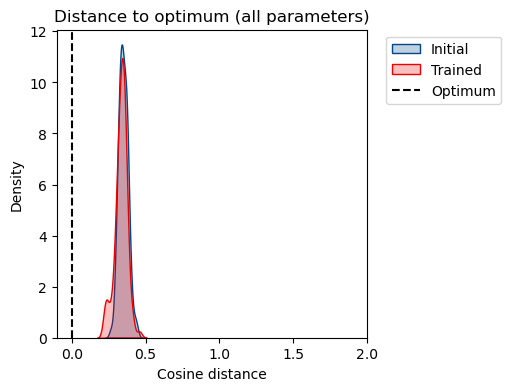

In [73]:
model_names = os.listdir("results/EXP1_initialization_bounds_lhs_V2")

results_dir = "results/EXP1_initialization_bounds_lhs_V2/"

model_names = ["Becker_Science2010"]
for model_name in model_names:
    results_dir = "results/EXP1_initialization_bounds_lhs_V2/" + model_name + "/"
    file_list = os.listdir(results_dir)
    loss_dfs, params_dfs, norms_dfs = hf.retrieve_convergence_results(results_dir, file_list)
    # model_success_dict[model_name]=hf.retrieve_success_rate(loss_dfs,model_name)


runs = ["run_1", "run_2", "run_3"]
fig, ax = plt.subplots(figsize=(4, 4))
for runid in runs:
    filepath = "models/sbml_models/working_models/" + model_name + ".xml"
    model = SBMLModel(file_path=filepath)
    params = get_global_parameters(model.model)
    true_params = {**model.local_params, **params}

    dist_init = []
    dist_training = []
    bound = "bounds_100.csv"
    file_name_trained = f"{model_name}_parameters_id_lhs_N=100{runid}{bound}"
    file_name_init = f"parameter_initializations/{model_name}/{model_name}_parameterset_id_lhs_N=100{runid}{bound}"

    # retrieve parameters from initializations
    parameter_initializations = pd.read_csv(file_name_init, index_col=0).T

    params_df = params_dfs[file_name_trained]

    for k, colname in enumerate(parameter_initializations.columns):
        dist = cosine_distance(true_params, parameter_initializations[k].to_dict())
        dist_init.append(dist)

    for k, colname in enumerate(params_df.columns):
        dist = cosine_distance(true_params, params_df[colname].to_dict())
        dist_training.append(dist)
dist_init = np.array(dist_init)
dist_training = np.array(dist_training)

sns.kdeplot(dist_init, fill=True, label="Initial", color="#00468BFF")
sns.kdeplot(dist_training, fill=True, label="Trained", color="#ED0000FF")
plt.axvline(0, linestyle="--", c="black", label="Optimum")
plt.xlim(-0.1, 2)
ax.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.xlabel("Cosine distance")
ax.set_title("Distance to optimum (all parameters)")
fig.savefig(f"figures/figures_parameter_distance/cosine_distance_all_params_{model_name}.png", bbox_inches="tight")
fig.savefig(f"figures/figures_parameter_distance/cosine_distance_all_params_{model_name}.svg", bbox_inches="tight")
plt.show()

### PCA plot for the model

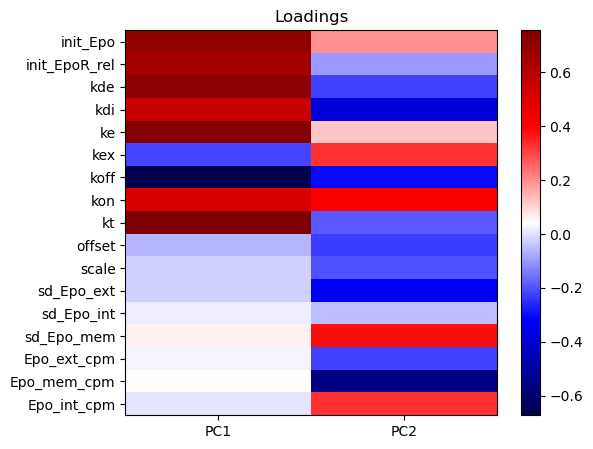

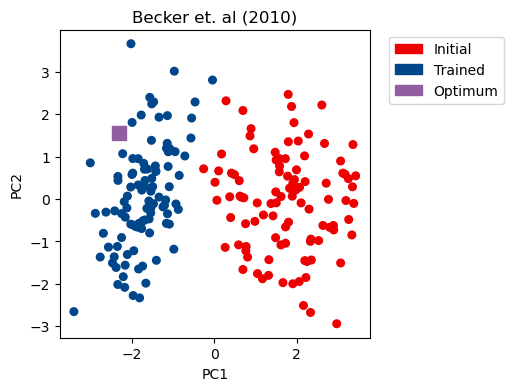

In [74]:
# make labels, and color the true optimum point with a seperate label
labels = np.zeros(np.shape(parameter_initializations)[1])
labels2 = np.ones(np.shape(params_df)[1])
labels3 = np.array([2])
labels = np.concatenate([labels, labels2, labels3])
params = pd.concat([parameter_initializations, params_df, pd.Series(true_params)], axis=1).T
pca = PCA(n_components=2)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(params)
X_embedded = pca.fit_transform(scaled_data)
fig, ax = plt.subplots(figsize=(6, 5))
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
im = ax.imshow(loadings, aspect="auto", cmap="seismic")
ax.set_yticks(np.arange(0, len(params.columns.to_list())), params.columns.to_list())
# ax.set_xlabel("Principal components")
ax.set_title("Loadings")
fig.colorbar(im)
ax.set_xticks(np.arange(0, 2, 1), ["PC1", "PC2"])
fig.savefig(f"figures/figures_parameter_distance/loadings_plot_{model_name}.png", bbox_inches="tight")
fig.savefig(f"figures/figures_parameter_distance/loadings_plot_{model_name}.svg", bbox_inches="tight")


plt.show()

sizes = np.full(len(labels), 30)
sizes[-1] = 100
lancet_cmap = ListedColormap(
    [
        "#ED0000FF",
        "#00468BFF",
    ]
)
fig, ax = plt.subplots(figsize=(4, 4))
ax.scatter(X_embedded[:-1, 0], X_embedded[:-1, 1], c=labels[:-1], cmap=lancet_cmap, s=sizes[:-1])
ax.scatter(X_embedded[-1, 0], X_embedded[-1, 1], c="#925E9FFF", s=sizes[-1], marker="s", label="optimum")
# Create legend entries for 'initial', 'trained', and 'optimum'
initial_patch = mpatches.Patch(color="#ED0000FF", label="Initial")  # Label 0 in red
trained_patch = mpatches.Patch(color="#00468BFF", label="Trained")  # Label 1 in blue
optimum_patch = mpatches.Patch(color="#925E9FFF", label="Optimum")  # Last point in purple

# Add custom legend with patches
ax.legend(handles=[initial_patch, trained_patch, optimum_patch], bbox_to_anchor=(1.04, 1), loc="upper left")
ax.set_title(literature_names[model_name])
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
fig.savefig(f"figures/figures_parameter_distance/PCA_plot_{model_name}.png", bbox_inches="tight")
fig.savefig(f"figures/figures_parameter_distance/PCA_plot_{model_name}.svg", bbox_inches="tight")

0.087095784641231
0.7987626498421341


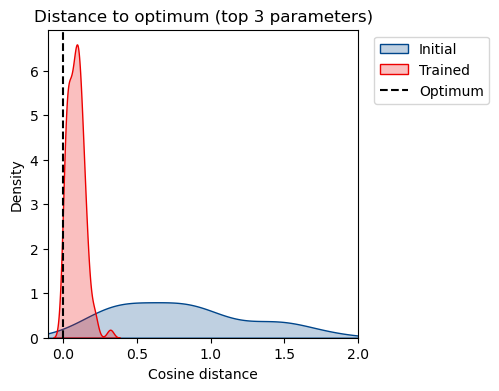

In [77]:
topX = 3
top10_ind = np.argsort(np.abs(loadings[:, 0]))[::-1][0:topX]
top10 = np.sort(np.abs(loadings[:, 0]))[::-1][0:topX]
selected_parameters = params.iloc[:, top10_ind].columns.tolist()

selected_true_params = {}
for i in selected_parameters:
    selected_true_params[i] = true_params[i]


for runid in runs:
    filepath = "models/sbml_models/working_models/" + model_name + ".xml"
    model = SBMLModel(file_path=filepath)
    # params = get_global_parameters(model.model)
    # true_params = {**model.local_params, **params}

    dist_init = []
    dist_training = []
    bound = "bounds_100.csv"
    file_name_trained = f"{model_name}_parameters_id_lhs_N=100{runid}{bound}"
    file_name_init = f"parameter_initializations/{model_name}/{model_name}_parameterset_id_lhs_N=100{runid}{bound}"

    # retrieve parameters from initializations
    parameter_initializations = pd.read_csv(file_name_init, index_col=0)

    parameter_initializations = parameter_initializations.loc[:, selected_parameters].T

    params_df = params_dfs[file_name_trained].T

    params_df = params_df[selected_parameters].T
    # print(parameter_initializations)

    for k, colname in enumerate(parameter_initializations.columns):
        dist = cosine_distance(selected_true_params, parameter_initializations.iloc[:, k].to_dict())
        dist_init.append(dist)

    for k, colname in enumerate(params_df.columns):
        dist = cosine_distance(selected_true_params, params_df.iloc[:, k].to_dict())
        dist_training.append(dist)
dist_init = np.array(dist_init)
dist_training = np.array(dist_training)

print(np.mean(dist_training))
print(np.mean(dist_init))

fig, ax = plt.subplots(figsize=(4, 4))
sns.kdeplot(dist_init, fill=True, label="Initial", color="#00468BFF")
sns.kdeplot(dist_training, fill=True, label="Trained", color="#ED0000FF")
plt.axvline(0, linestyle="--", c="black", label="Optimum")
plt.xlim(-0.1, 2)
ax.legend(bbox_to_anchor=(1.03, 1), loc="upper left")
ax.set_title("Distance to optimum (top 3 parameters)")
plt.xlabel("Cosine distance")
fig.savefig(f"figures/figures_parameter_distance/cosine_distance_top3loadings_params_{model_name}.png", bbox_inches="tight")
fig.savefig(f"figures/figures_parameter_distance/cosine_distance_top3loadings_params_{model_name}.svg", bbox_inches="tight")
plt.show()

In [76]:
selected_parameters

['kt', 'ke', 'kde']